# Predicting Attrition

In [1]:
import pandas as pd
import csv
import warnings

import sys
sys.path.insert(0, 'utils/')
from utils_attrition import *

warnings.filterwarnings('ignore')
from pivottablejs import pivot_ui
from IPython.core.display import HTML
from itertools import repeat
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 2)

## Problem description

This notebook accompanies the Online Panel Study 2017 (doi: 10.11587/I7QIYJ) conducted by the Austrian
National Election Study (**AUTNES**). The six wave panel focuses on the Austrian National Parliamentary Election held on 15 October 2017. 

The notebook is aimed to investigate the attrition of survey participants across waves. Sometimes respondents tend to skip the study in the following waves and some of them come back in later waves. However, missing information impairs the quality of panel dataset in general. Thus, we try to predict which participants are more likely to drop the survey. The questions are the following:
* is there a typical portrait of such a person, basing on personal features? Does it make sense to filter more participants with some features?
* which factors affect dependent variable? Does their opinion matter for attrition?

The approach is to make classification wave-wise (e.g. taking data from the first wave and use it to predict attrition in the second wave, then use features from the second wave to forecast wave 3, etc). Then we take actual data from latter waves to evaluate models.
We left the proportions between 'dropped' and 'stayed' class the same in both test and train sets (which is important for imbalanced  dataset).

In [2]:
# pick arbitrary wave for demonstration
wave = 3
names = ['drop', 'stay']
personal, political, y = import_data(wave)
horizontal_line(), h2centered(f'Wave {wave}'), y_counter(y)

,panelpat
stayed,2683
dropped,450


(None, None, None)

The two classes are quite __unbalanced__...

# Metrics used

We use different subsets of independent features (4 in total) to predict attrition in the survey.
In order to evaluate quality of models and predictions we use some metrics, which are based on confusion matrix:

|                        | Real positive                   | Real negative                   |   |   |
|------------------------|---------------------------------|---------------------------------|---|---|
| **Predicted positive** | <mark>True positive (TP)</mark> | False positive (FP)             |   |   |
| **Predicted negative** | False negative (FN)             | <mark>True negative (TN)</mark> |   |   |
|                        |                                 |                                 |   |   |
|                        |                                 |                                 |   |   |


We computed the following evaluation metrics:

|                   | Measures                                                                                          |   |   |
|-------------------|---------------------------------------------------------------------------------------------------|---|---|
| **Precision**     | How many observations predicted as positive are in fact positive                                  |   |   |
| **Recall**        | How many observations out of all positive observations have we classified as positive             |   |   |
| **Accuracy**      | How many observations, both positive and negative, were correctly classified                      |   |   |

The models were tested with training set and test set (30% of samples are test, seed is not random for results to be comparable).

We store all the performance metrics in df, called **performance**. Each time it is called, we concatenate new results 

# Models used

### Logistic Regression

One of the most well-studied models there are. It has very strong theoretical/statistical backing (if certain conditions are met). Even nonlinear dependencies on features can be modeled by adding the as columns before the fitting process.

In [3]:
def logistic_regression(X_train, y_train, X_test, y_test, names, performance):
    clf = LogisticRegression(max_iter=10000, class_weight='balanced')
    clf.fit(X_train, y_train)

    fancy_output_for_lr(clf.coef_, X_train)
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

### Decision Trees

In [4]:
def decision_tree(X_train, y_train, X_test, y_test, names, performance):
    tree_params = {'min_samples_leaf': [50, 100, 250]}
    clf = GridSearchCV(DecisionTreeClassifier(max_depth=4, class_weight='balanced'), tree_params) 
    clf.fit(X_train, y_train)
    prune_duplicate_leaves(clf.best_estimator_)
    fancy_plotting_for_DT(clf, X_train, names)
    
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

### Support Vector Machine

In [5]:
def SVM_default(X_train, y_train, X_test, y_test, names, performance):
    clf = LinearSVC(max_iter=10000, class_weight='balanced')
    clf.fit(X_train, y_train)

    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

def RBF_SVM(X_train, y_train, X_test, y_test, names, performance):
    """Kernel Support Vector Machine using a radial basis function."""
    clf = SVC(probability=True, class_weight='balanced')
    clf.fit(X_train, y_train)

    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

def models_without_output(X_train, y_train, X_test, y_test, names, performance):
    """just to plot the performance metrics at the end, without the most important features print"""
    performance = SVM_default(X_train, y_train, X_test, y_test, names, performance)
    performance = RBF_SVM(X_train, y_train, X_test, y_test, names, performance)
    return performance

# ensemble models are omitted due to obtaining similar results as other models with longer waiting times

In total we have 6 waves, the task is to predict attrition of the participants, based on previous waves. However, for demonstration purposes we leave only 1 wave

# Run methods using different features

## Using only personal features

In [6]:
X = personal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Run methods

Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100)

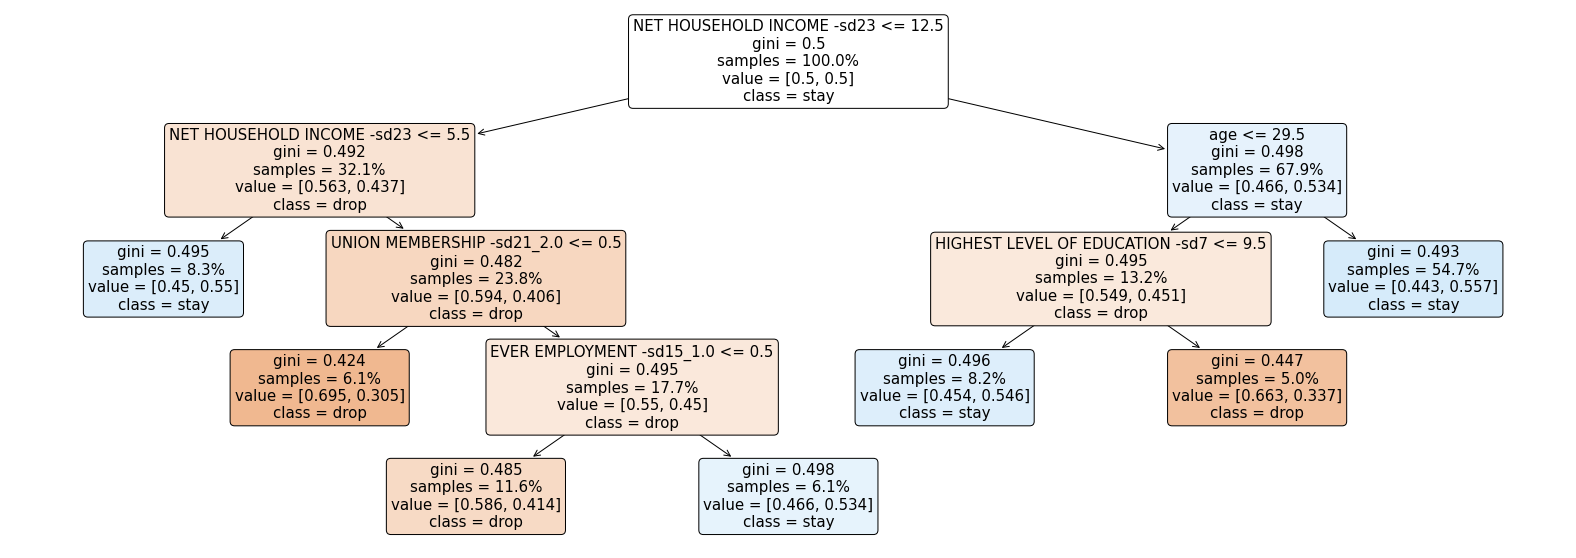

In [7]:
performance = decision_tree(X_train, y_train, X_test, y_test, names, performance)

In [8]:
X_train, X_test = scale_train(X_train, X_test)
performance = logistic_regression(X_train, y_train, X_test, y_test, names, performance)

,coef
CURRENT PERSONAL SITUATION -sd10_5.0,-1.21
OTHER OCCUPATION -sd12_3.0,1.06
"Country of birth, mother -sd19_2.0",0.90
ADDITIONAL OCCUPATION -sd13_2.0,0.89
RELIGIOUS AFFILIATION -sd8_5.0,-0.89
GENDER -sd3_3.0,-0.87
"Country of birth, father -sd20_3.0",-0.80
CURRENT PERSONAL SITUATION -sd10_3.0,0.79
OTHER OCCUPATION -sd12_1.0,-0.74
ADDITIONAL OCCUPATION -sd13_4.0,-0.71


The sign of the coefficients has a simple interpretation: __negative__ means that a higher value in this feature corresponds to a lower probability to stay - and vice versa.

In [9]:
performance = models_without_output(X_train, y_train, X_test, y_test, names, performance)

## Using All features (personal, political & engineered)

Here we add samples, which were missing in previous wave(s). We use their data from the last wave the have participated.

In [10]:
X = pd.concat([personal, political], axis=1)

# removing redundant features and labels
dte = X.filter(like='_dte', axis=1)
X = X.drop(['participated_only_once', dte.columns[0]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Run methods

Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=50)

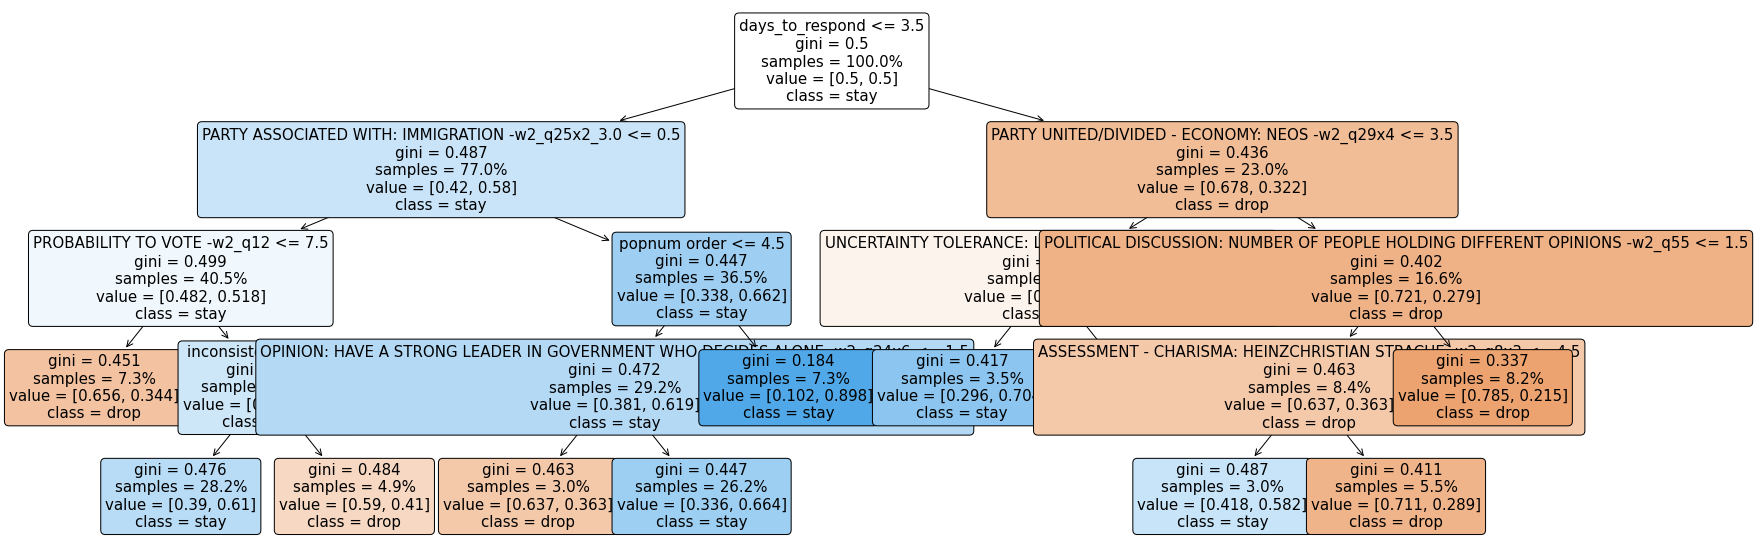

In [11]:
performance = decision_tree(X_train, y_train, X_test, y_test, names, performance)

We see that the some of the most important features for the DT model were:
- how many days it took people to respond to the survey
- and how propable they think they are to vote in the next election

In [12]:
X_train, X_test = scale_train(X_train, X_test)
performance = logistic_regression(X_train, y_train, X_test, y_test, names, performance)

,coef
days_to_respond,-2.43
"OPINION: THE PEOPLE SHOULD TAKE MOST IMPORTANT DECISIONS, NOT POLITICIANS -w2_q24x7",1.94
OTHER OCCUPATION -sd12_1.0,-1.51
PERSONAL ECONOMIC SITUATION -w2_q30,-1.49
PARTY CHOICE: HYPOTHETICAL -w2_q14_6.0,-1.44
PARTY ASSOCIATED WITH: ENVIRONMENTAL PROTECTION -w2_q25x5_66.0,-1.43
PREFERRED COALITION: OEVP-GREENSNEOS -w2_q38x2,1.39
LIKELIHOOD OF ENTERING PARLIAMENT: THE GREENS -w2_q39x1,-1.35
LIKE-DISLIKE: MATTHIAS STROLZ -w2_q6x5,1.31
RELIGIOUS AFFILIATION -sd8_5.0,-1.27


In [13]:
performance = models_without_output(X_train, y_train, X_test, y_test, names, performance)

# Results

In [14]:
# prettifying df to present results
performance *= 100 # convert to %
features = ['all'] * 8 + ['personal'] * 8 # list of 4 models total for each subset x2 for each split => 8
features = pd.DataFrame(features, columns=['Subset']).T
cols = ['LR', 'DT', 'SVM', 'RBF_SVM']*2 # list of models used

performance.columns = cols
performance = performance.T
performance.columns = [['Train', 'Train', 'Train', 'Test', 'Test', 'Test'], ['Recall', 'Precision', 'Accuracy', 'Recall', 'Precision', 'Accuracy']]
performance = performance.apply(pd.to_numeric, errors='ignore')
performance = performance.stack(0).reset_index()
performance = pd.concat([performance, features.T], axis=1)
performance.rename(columns={'level_0':'Model', 'level_1':'Split'}, inplace=True)
performance['Accuracy'] = performance['Accuracy'].round(1)

In [44]:
fig = px.scatter(performance, title="Precision/recall/accuracy scatter plots", x="Recall", y="Precision", color="Model", text='Accuracy', facet_col="Split", facet_row="Subset")
fig.update_traces(textposition="middle right", textfont_size=5)
fig.update_layout(legend=dict(font=dict(size=8),
    orientation="h",
    yanchor="bottom",
    y=1, title=' ',
    xanchor="right",
    x=1),
    width=550,
    height=400, legend_title=dict(font=dict(size=8)))
# subplot title fonts size
fig.update_annotations(font_size=8)
fig.add_annotation(dict(font=dict(color='black', size=8),
                                        x=0,
                                        y=-.25,
                                        showarrow=False,
                                        text="Accuracy is represented by numbers next to dots",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.update_xaxes(dict(tickfont = dict(size=8)), title_font=dict(size=8), range=[10, 62])
fig.update_yaxes(dict(tickfont = dict(size=8)), title_font=dict(size=8), range=[10, 18.5])
fig.write_image("Precision_recall_accuracy_plots.png", scale=10)

![ ](Precision_recall_accuracy_plots.png)

Although the newly introduced features in the larger dataset (using all questions+engineered features) seemed to be very relevant to the models it is not so clear whether they performed better. 

# References

1. Wagner, Markus, Julian Aichholzer, Jakob-Moritz Eberl, Thomas Meyer, Nicolai Berk, Nico Büttner, Hajo
Boomgaarden, Sylvia Kritzinger and Wolfgang C. Müller (2020). AUTNES Online Panel Study 2017 (SUF
Edition). Vienna: AUSSDA (doi:10.11587/I7QIYJ).

2. Wagner, Markus, Julian Aichholzer, Jakob-Moritz Eberl, Thomas Meyer, Nicolai Berk, Nico Büttner, Hajo
Boomgaarden, Sylvia Kritzinger and Wolfgang C. Müller (2020). AUTNES Online Panel Study 2017 –
Documentation. Vienna: AUSSDA (doi:10.11587/I7QIYJ).